In [2]:
from ultralytics import YOLOv10
import numpy as np
import torch
import gc

# Correcting the deprecated usage of np.bool
np.bool = np.bool_

# Model configuration
id = "bdd"
model_type = "v10s"
batch_size = 4  # You can reduce this if memory issues persist
img_size = 800  # You can also reduce this if necessary
ood_datasets = ["ID-voc-OOD-coco", "OOD-open"] if id == "voc" else ["ID-bdd-OOD-coco", "OOD-open", "voc-ood"]

# FX

In [2]:
# Load the model once
model = YOLOv10(f"/home/hugo/yolov10/models/{model_type}_{id}/best.engine", task="detect")

# Validation on different splits
for split in ["train", "val"]:
    model.val(
        data=f"/home/hugo/datasets/{id}/dataset.yaml", 
        batch=batch_size,
        imgsz=img_size,
        verbose=False,
        device="cuda",
        split=split, 
        save_json=True,
        project=f"/home/hugo/yolov10FX/feats/{model_type}_{id}",
        name=f"{id}-{split}"
    )
    torch.cuda.empty_cache()
    gc.collect()

# Validation on out-of-domain datasets
for dataset_name in ood_datasets:
    model.val(
        data=f"/home/hugo/datasets/{dataset_name}/dataset.yaml", 
        batch=batch_size,
        imgsz=img_size,
        verbose=False,
        device="cuda",
        save_json=True,
        project=f"/home/hugo/yolov10FX/feats/{model_type}_{id}",
        name=f"{dataset_name}"
    )
    torch.cuda.empty_cache()
    gc.collect()


Ultralytics YOLOv8.1.34 🚀 Python-3.9.19 torch-2.0.1+cu117 CUDA:0 (NVIDIA RTX A4000 Laptop GPU, 8192MiB)
Loading /home/hugo/yolov10/models/v10s_bdd/best.engine for TensorRT inference...
[06/20/2024-23:10:22] [TRT] [I] Loaded engine size: 30 MiB
[06/20/2024-23:10:23] [TRT] [I] [MemUsageChange] Init cuDNN: CPU +1245, GPU +34, now: CPU 1484, GPU 1137 (MiB)
[06/20/2024-23:10:23] [TRT] [W] TensorRT was linked against cuDNN 8.6.0 but loaded cuDNN 8.5.0
[06/20/2024-23:10:23] [TRT] [I] [MemUsageChange] TensorRT-managed allocation in engine deserialization: CPU +0, GPU +27, now: CPU 0, GPU 27 (MiB)
[06/20/2024-23:10:23] [TRT] [I] [MemUsageChange] Init cuDNN: CPU +0, GPU +32, now: CPU 1454, GPU 1137 (MiB)
[06/20/2024-23:10:23] [TRT] [W] TensorRT was linked against cuDNN 8.6.0 but loaded cuDNN 8.5.0
[06/20/2024-23:10:23] [TRT] [I] [MemUsageChange] TensorRT-managed allocation in IExecutionContext creation: CPU +0, GPU +481, now: CPU 0, GPU 508 (MiB)


val: Scanning /home/hugo/datasets/bdd/labels/train... 69853 images, 147 backgrounds, 0 corrupt: 100%|██████████| 70000/70000 [01:02<00:00, 1126.52it/s]


val: New cache created: /home/hugo/datasets/bdd/labels/train.cache


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  77%|███████▋  | 6730/8750 [29:06<08:44,  3.85it/s]    


# Predictions preprocess

In [3]:
import numpy as np
import ijson

def json2npy(model_type, id, threshold, dataset_name):
    file_path = f"/home/hugo/yolov10FX/feats/{model_type}_{id}/{dataset_name}/predictions.json"
    
    logits = []
    labels = []

    # Use ijson to parse the JSON file incrementally
    with open(file_path, 'r') as f:
        objects = ijson.items(f, 'item')
        for obj in objects:
            if obj["score"] > threshold:
                logits.append(obj["logits"])
                labels.append(obj["category_id"])

    # Convert lists to NumPy arrays once at the end
    logits = np.array(logits, dtype=np.float32)
    labels = np.array(labels, dtype=np.int32)



    # Save the arrays to disk
    np.save(f"/home/hugo/yolov10FX/feats/{model_type}_{id}/{dataset_name}/logits.npy", logits)
    np.save(f"/home/hugo/yolov10FX/feats/{model_type}_{id}/{dataset_name}/labels.npy", labels)


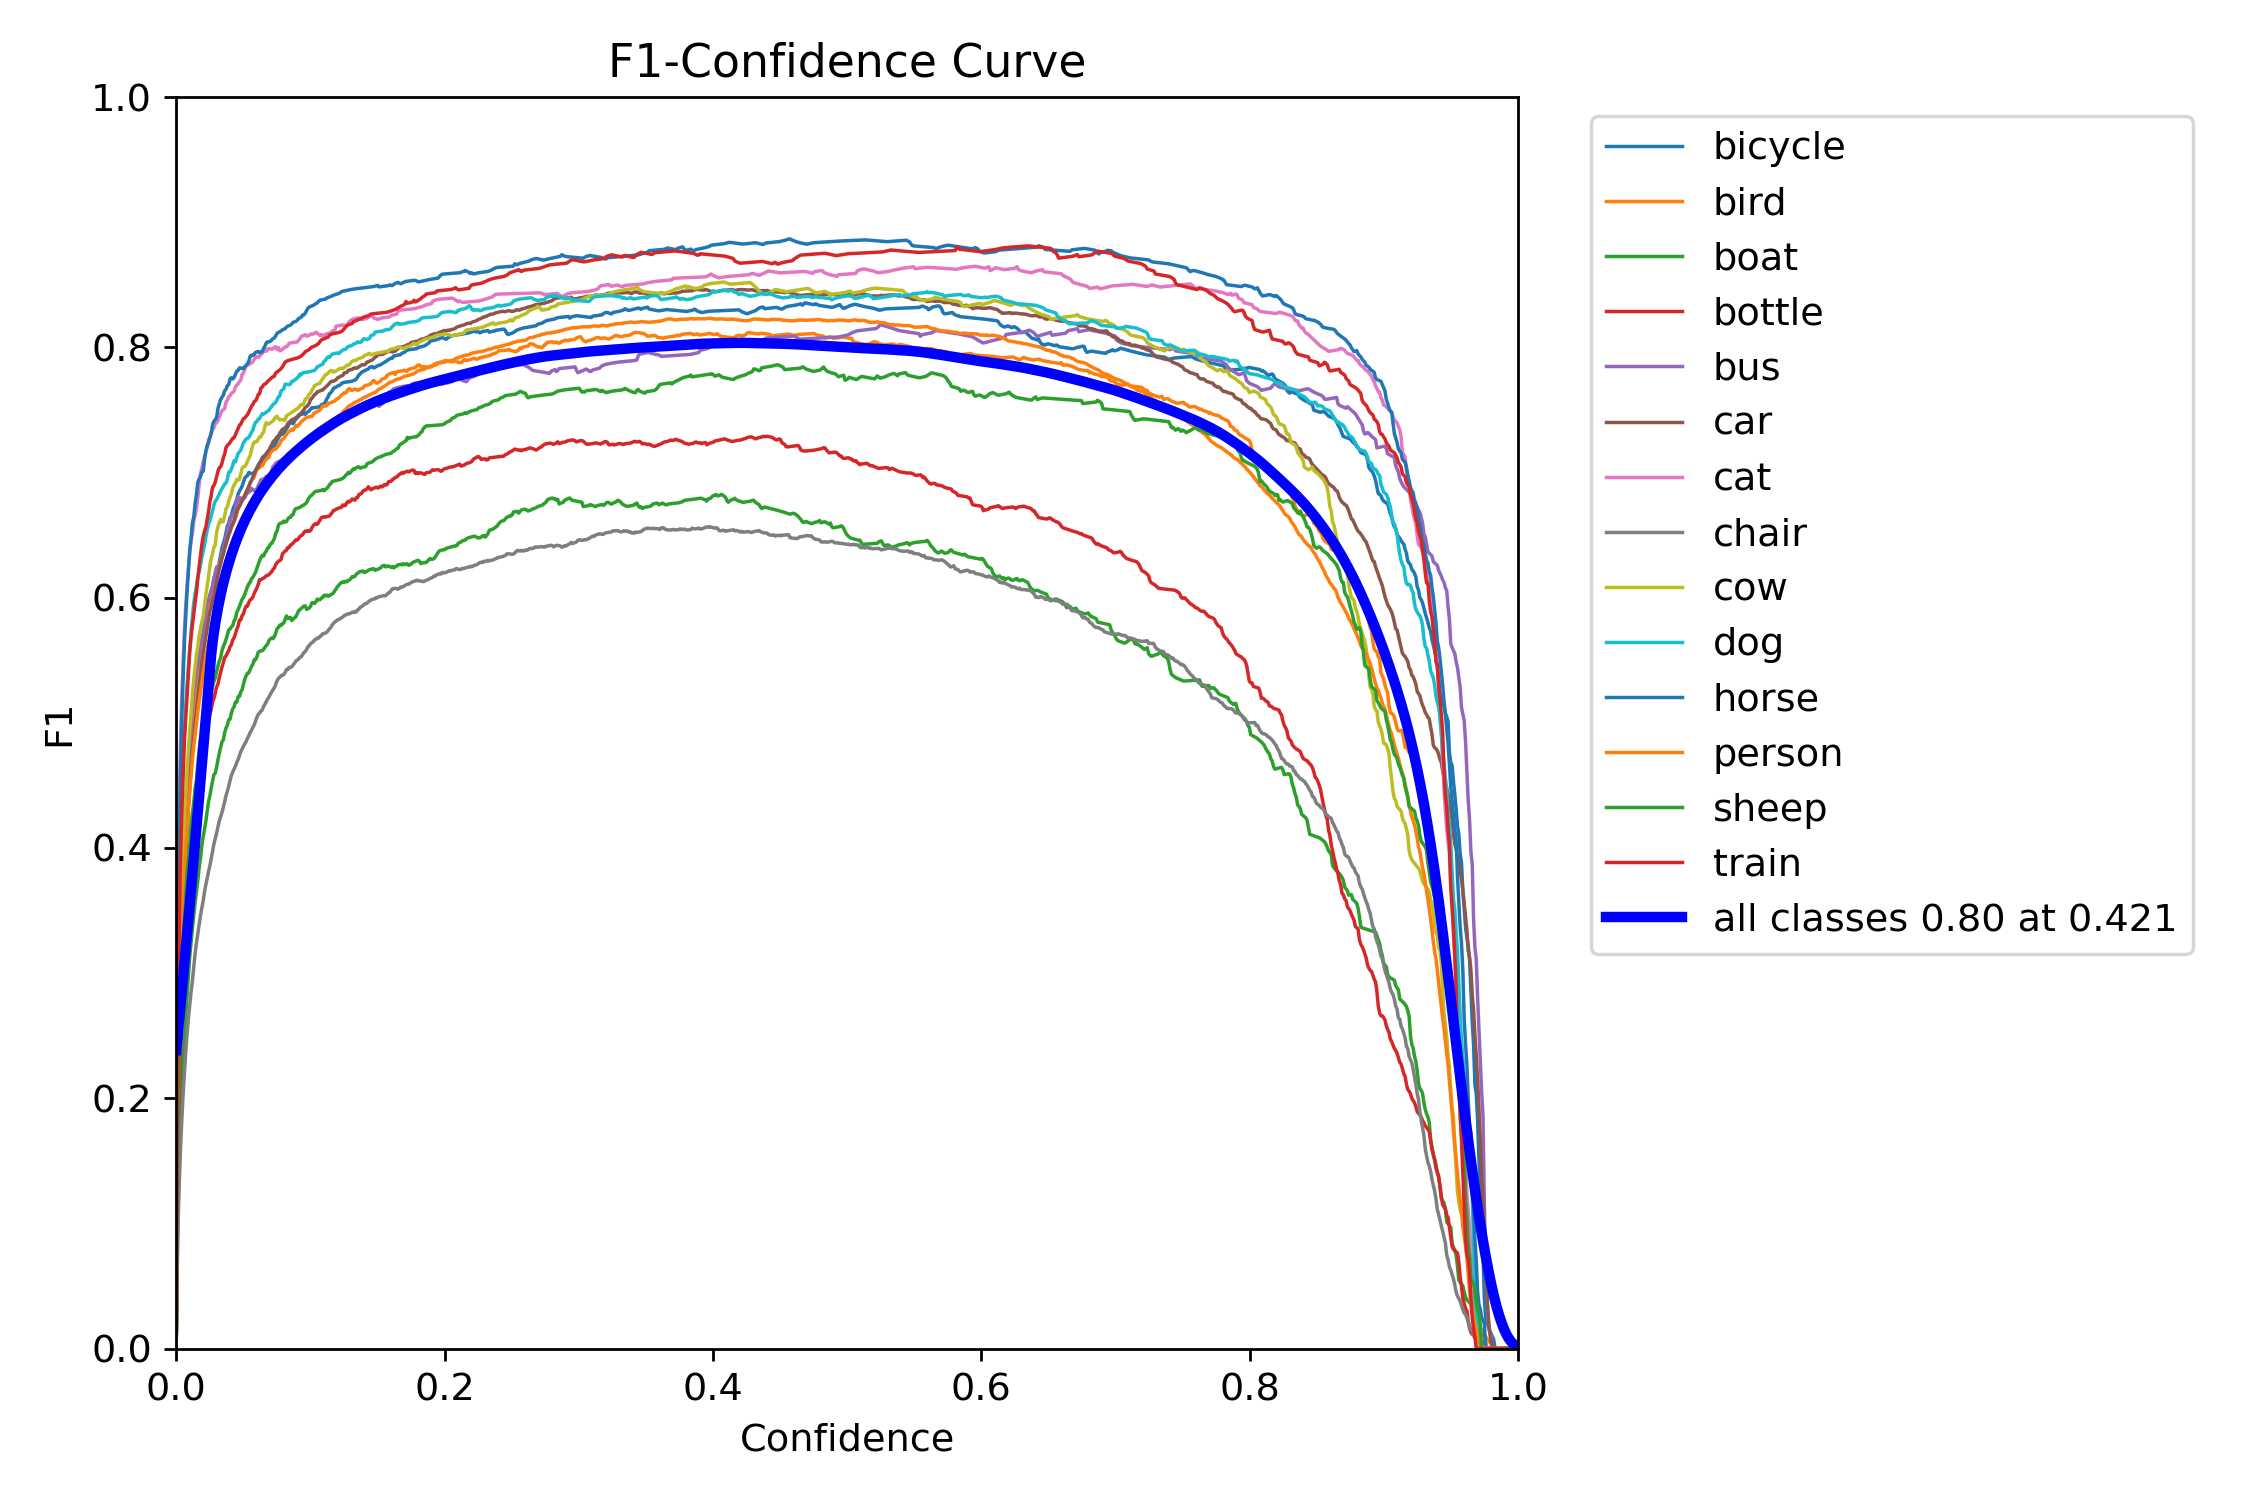

In [4]:
# from IPython.display import Image
# Image(filename='/home/hugo/yolov10FX/feats/v10s_voc/voc-val/F1_curve.png')

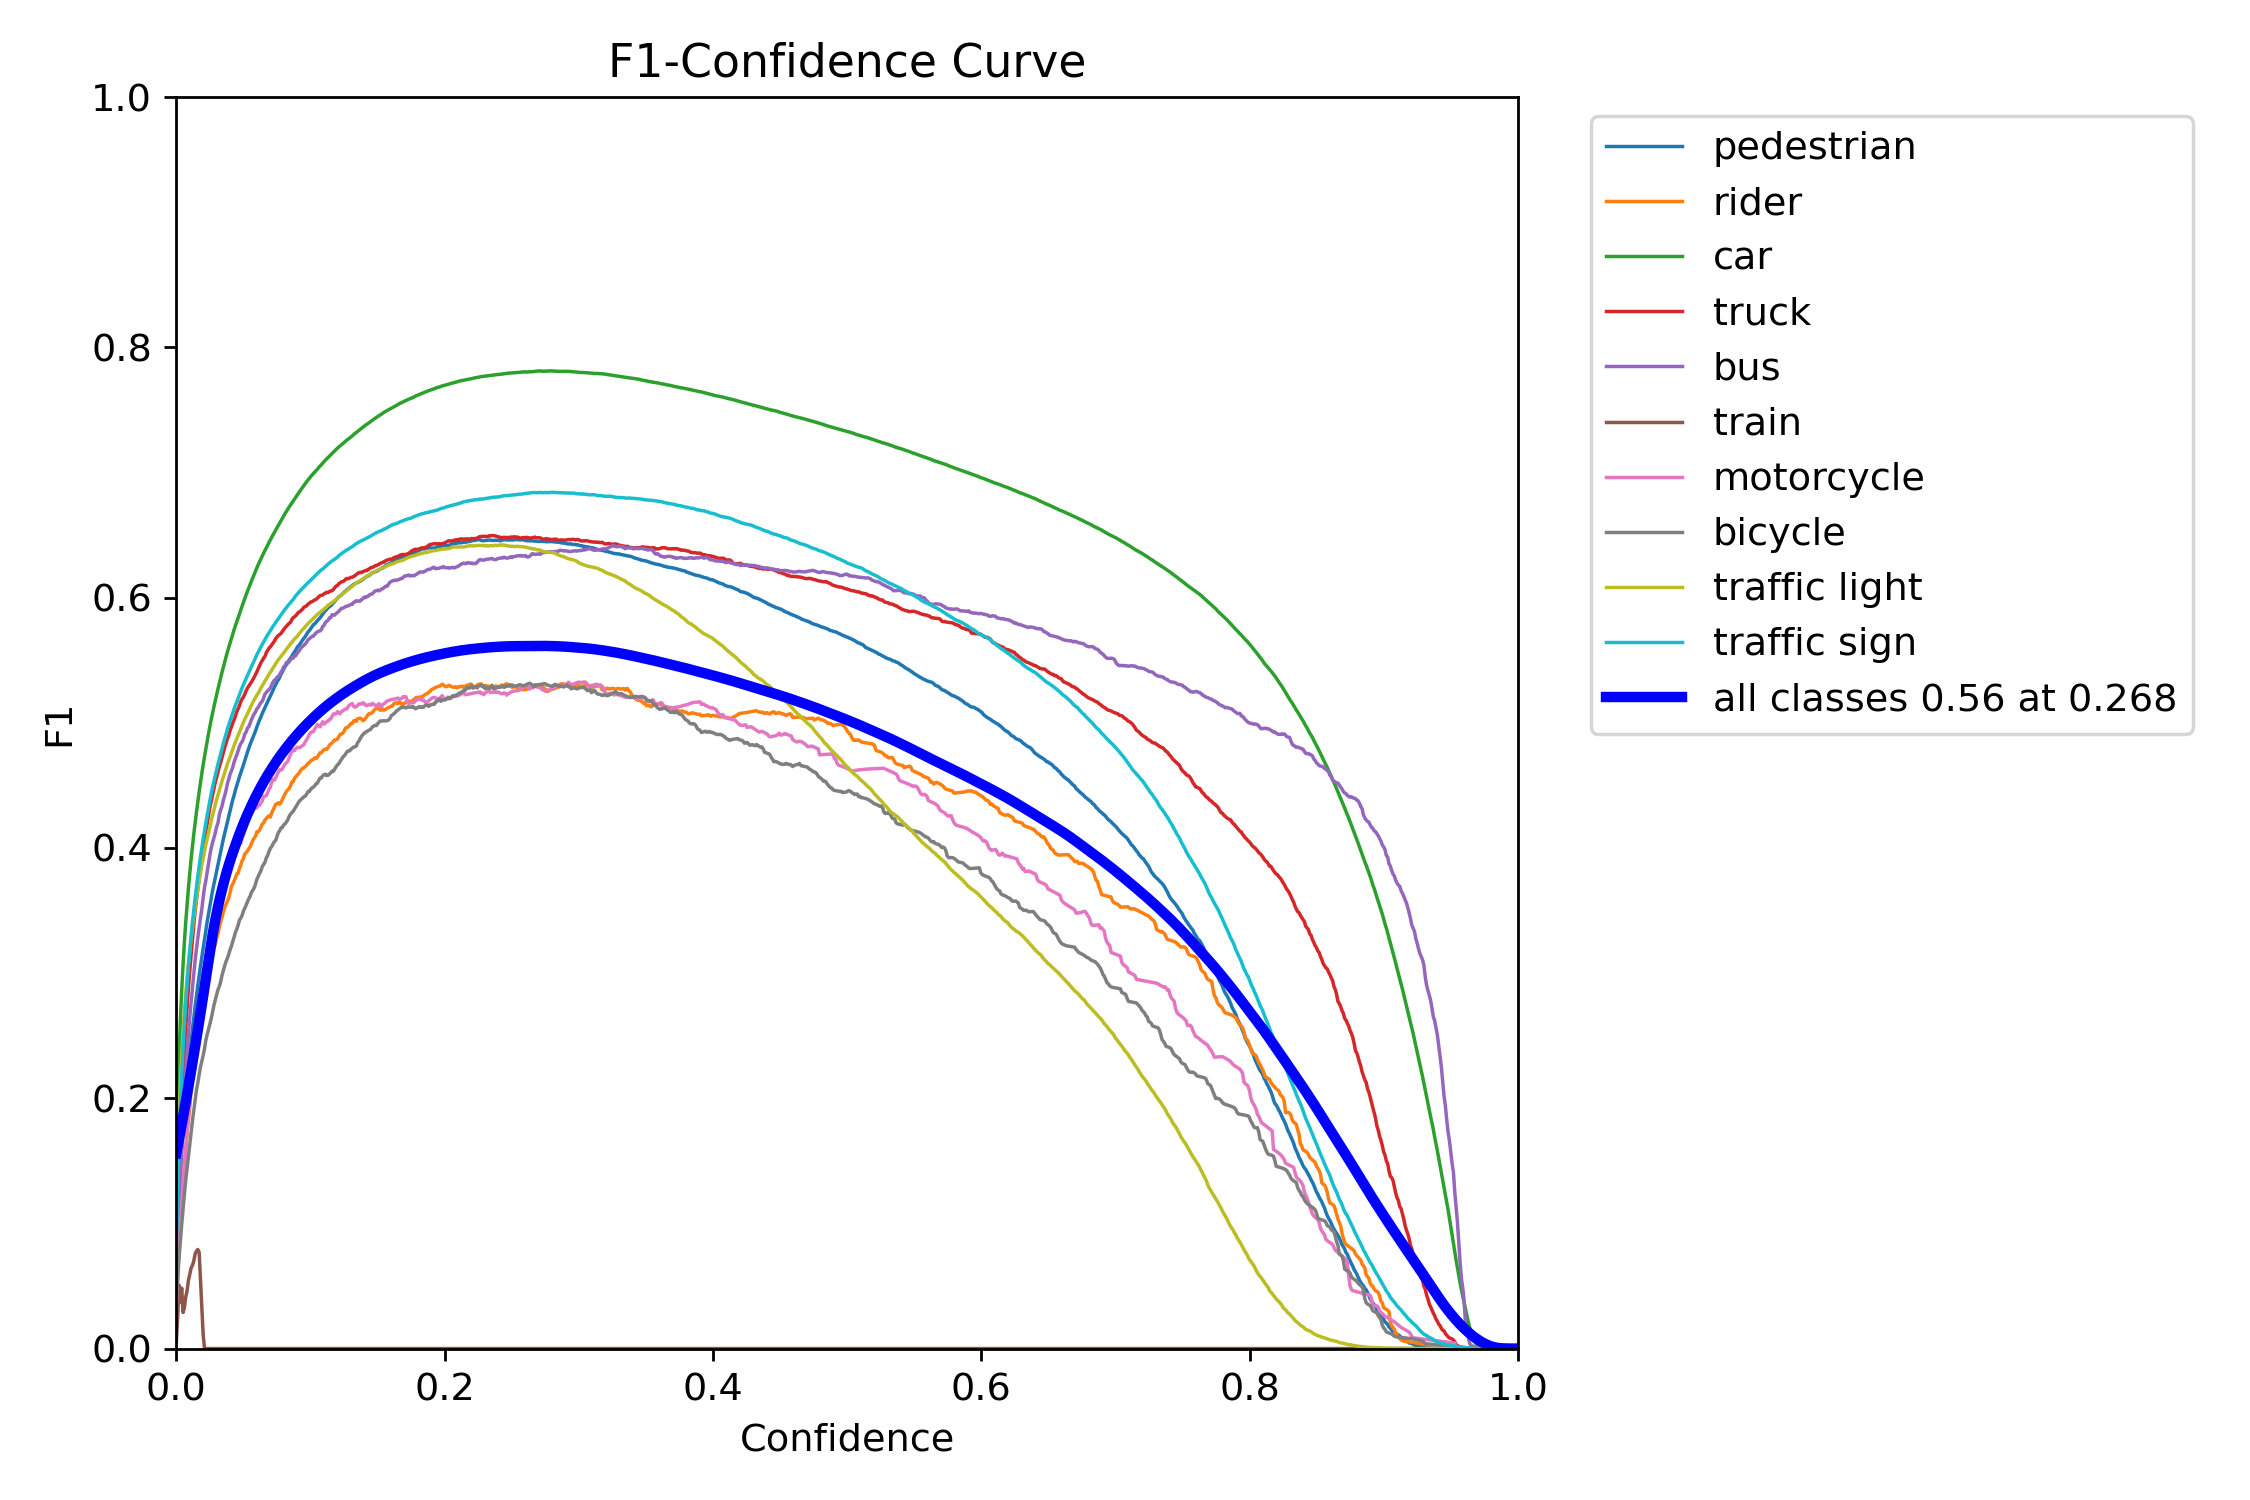

In [5]:
from IPython.display import Image
Image(filename=f'/home/hugo/yolov10FX/feats/v10s_{id}/{id}-val/F1_curve.png')

In [15]:
# import tqdm
# for dataset_name in tqdm.tqdm(["voc-train", "voc-val"] + ood_datasets):
#     json2npy(model_type, id, 0.421, dataset_name)

100%|██████████| 4/4 [00:56<00:00, 14.13s/it]


In [6]:
import tqdm
for dataset_name in tqdm.tqdm([f"{id}-train", f"{id}-val"] + ood_datasets):
    json2npy(model_type, id, 0.268, dataset_name)

100%|██████████| 5/5 [02:29<00:00, 29.84s/it] 


# Evaluation with scoring function

In [1]:
import torch 
import numpy as np
# build msp method (pass in pre-saved logits)
def msp_postprocess(logits):
    score = torch.softmax(logits, dim=1)
    conf, pred = torch.max(score, dim=1)
    return pred, conf
def ebo_postprocess(logits, temperature=1):
    score = torch.softmax(logits, dim=1)
    _, pred = torch.max(score, dim=1)
    conf = temperature * torch.logsumexp(logits / temperature,
                                                dim=1)
    return pred, conf
def maxlogits_postprocess(logits):
    conf, pred = torch.max(logits, dim=1)
    return pred, conf
import numpy as np
import torch
import sklearn.covariance

def mahalanobis_compute_mean(logits):
    num_classes = logits[0].shape[0]
    all_preds = np.array([logit.argmax(0) for logit in logits])
    all_preds = torch.from_numpy(all_preds)
    all_labels = all_preds
    all_feats = torch.from_numpy(logits)
    class_mean = []
    centered_data = []
    for c in range(num_classes):
        class_samples = all_feats[all_labels.eq(c)].data
        if class_samples.size(0) > 0:  # Check if there are samples for the class
            mean = class_samples.mean(0)
            centered = class_samples - mean.view(1, -1)
        else:  # If no samples, use a placeholder (e.g., zeros)
            feat_dim = all_feats.size(1)
            mean = torch.zeros(feat_dim)
            centered = torch.empty((0, feat_dim))  # Empty tensor with the correct second dimension
        class_mean.append(mean)
        centered_data.append(centered)

    # Ensure there's at least one class with samples to avoid errors in covariance calculation
    if len(torch.cat(centered_data)) == 0:
        raise ValueError("No samples available for any class to compute covariance.")
    
    group_lasso = sklearn.covariance.EmpiricalCovariance(assume_centered=False)
    group_lasso.fit(torch.cat(centered_data).cpu().numpy().astype(np.float32))
    precision = torch.from_numpy(group_lasso.precision_).float()
    return class_mean, precision

def mahalanobis_postprocess(logits, class_mean, precision):
    num_classes = logits[0].shape[0]
    pred = logits.argmax(1)
    precision = precision.double()
    class_scores = torch.zeros((logits.shape[0], num_classes))
    for c in range(num_classes):
        if class_mean[c].numel() > 0:  # Check if the class mean was computed
            # Efficient computation of Mahalanobis distance for each sample
            for i in range(logits.shape[0]):
                tensor = logits[i] - class_mean[c].double()
                # Here, we avoid the large matrix multiplication and directly compute the distance
                score = torch.dot(tensor, torch.matmul(precision, tensor))
                class_scores[i, c] = -score  # Negative score to match the original logic

    conf = torch.max(class_scores, dim=1)[0]
    return pred, conf

In [2]:
import numpy as np
import json
import torch
from openood.evaluators.metrics import compute_all_metrics
def process_and_evaluate(id, postprocess_method, dataset_names, modes=['train', 'val']):
    results = dict()
    results['id'] = dict()
    for mode in modes:
        results['id'][mode] = dict()
        results['id'][mode]['logits'] = np.load(f"/home/hugo/yolov10FX/feats/{model_type}_{id}/{id}-{mode}/logits.npy")
        results['id'][mode]['labels'] = np.load(f"/home/hugo/yolov10FX/feats/{model_type}_{id}/{id}-{mode}/labels.npy")

    results['ood'] = dict()
    for dataset_name in dataset_names:
        results['ood'][dataset_name] = dict()
        results['ood'][dataset_name]['logits'] = np.load(f'/home/hugo/yolov10FX/feats/{model_type}_{id}/{dataset_name}/logits.npy')
        results['ood'][dataset_name]['labels'] = np.full((results['ood'][dataset_name]['logits'].shape[0], ), -1)
    # print("loading done")
    postprocess_results = dict()
    postprocess_results['id'] = dict()
    if postprocess_method == mahalanobis_postprocess:
        class_mean, precision = mahalanobis_compute_mean(results['id']['train']['logits'])
        del results['id']['train']
        pred, conf = postprocess_method(torch.from_numpy(results['id']['val']['logits']), class_mean, precision)
    else:
        pred, conf = postprocess_method(torch.from_numpy(results['id']['val']['logits']))
    
    pred, conf = pred.numpy(), conf.numpy()
    gt = results['id'][mode]['labels']
    postprocess_results['id'][mode] = [pred, conf, gt]
    # print("ID processing done")
    postprocess_results['ood'] = dict()
    for dataset_name in dataset_names:
        if postprocess_method == mahalanobis_postprocess:
            pred, conf = postprocess_method(torch.from_numpy(results['ood'][dataset_name]['logits']), class_mean, precision)
        else:
            pred, conf = postprocess_method(torch.from_numpy(results['ood'][dataset_name]['logits']))
        pred, conf = pred.numpy(), conf.numpy()
        gt = results['ood'][dataset_name]['labels']
        gt = -1 * np.ones_like(gt)
        postprocess_results['ood'][dataset_name] = [pred, conf, gt]
    # print("OOD processing done")
    return eval_ood(postprocess_results, dataset_names)

def eval_ood(postprocess_results, dataset_names):
    [id_pred, id_conf, id_gt] = postprocess_results['id']['val']
    metrics_list = []
    fpr95 = []
    for dataset_name in dataset_names:
        [ood_pred, ood_conf, ood_gt] = postprocess_results['ood'][dataset_name]

        pred = np.concatenate([id_pred, ood_pred])
        conf = np.concatenate([id_conf, ood_conf])
        label = np.concatenate([id_gt, ood_gt])

        ood_metrics = compute_all_metrics(conf, label, pred)
        fpr95.append(ood_metrics[0])
        metrics_list.append(ood_metrics)
    metrics_list = np.array(metrics_list)
    metrics_mean = np.mean(metrics_list, axis=0)   
    fpr95.append(metrics_mean[0])
    return [round(fpr, 4) for fpr in fpr95]

In [3]:
import numpy as np
import json
import torch
import gc
from openood.evaluators.metrics import compute_all_metrics

def process_and_evaluate(id, postprocess_method, dataset_names, modes=['train', 'val']):
    results = dict()
    results['id'] = dict()

    # Load and process ID data
    for mode in modes:
        results['id'][mode] = dict()
        logits_path = f"/home/hugo/yolov10FX/feats/{model_type}_{id}/{id}-{mode}/logits.npy"
        labels_path = f"/home/hugo/yolov10FX/feats/{model_type}_{id}/{id}-{mode}/labels.npy"
        results['id'][mode]['logits'] = np.load(logits_path, mmap_mode='r')
        results['id'][mode]['labels'] = np.load(labels_path, mmap_mode='r')

    results['ood'] = dict()

    # Load and process OOD data
    for dataset_name in dataset_names:
        results['ood'][dataset_name] = dict()
        logits_path = f'/home/hugo/yolov10FX/feats/{model_type}_{id}/{dataset_name}/logits.npy'
        results['ood'][dataset_name]['logits'] = np.load(logits_path, mmap_mode='r')
        results['ood'][dataset_name]['labels'] = np.full((results['ood'][dataset_name]['logits'].shape[0], ), -1)

    postprocess_results = dict()
    postprocess_results['id'] = dict()

    if postprocess_method == mahalanobis_postprocess:
        class_mean, precision = mahalanobis_compute_mean(results['id']['train']['logits'])
        del results['id']['train']
        torch.cuda.empty_cache()
        gc.collect()
        pred, conf = postprocess_method(torch.from_numpy(results['id']['val']['logits']), class_mean, precision)
    else:
        pred, conf = postprocess_method(torch.from_numpy(results['id']['val']['logits']))

    pred, conf = pred.numpy(), conf.numpy()
    gt = results['id']['val']['labels']
    postprocess_results['id']['val'] = [pred, conf, gt]

    del results['id']
    torch.cuda.empty_cache()
    gc.collect()

    postprocess_results['ood'] = dict()

    for dataset_name in dataset_names:
        if postprocess_method == mahalanobis_postprocess:
            pred, conf = postprocess_method(torch.from_numpy(results['ood'][dataset_name]['logits']), class_mean, precision)
        else:
            pred, conf = postprocess_method(torch.from_numpy(results['ood'][dataset_name]['logits']))

        pred, conf = pred.numpy(), conf.numpy()
        gt = results['ood'][dataset_name]['labels']
        postprocess_results['ood'][dataset_name] = [pred, conf, gt]

        del results['ood'][dataset_name]
        torch.cuda.empty_cache()
        gc.collect()

    return eval_ood(postprocess_results, dataset_names)

def eval_ood(postprocess_results, dataset_names):
    [id_pred, id_conf, id_gt] = postprocess_results['id']['val']
    metrics_list = []
    fpr95 = []

    for dataset_name in dataset_names:
        [ood_pred, ood_conf, ood_gt] = postprocess_results['ood'][dataset_name]

        pred = np.concatenate([id_pred, ood_pred])
        conf = np.concatenate([id_conf, ood_conf])
        label = np.concatenate([id_gt, ood_gt])

        ood_metrics = compute_all_metrics(conf, label, pred)
        fpr95.append(ood_metrics[0])
        metrics_list.append(ood_metrics)

    metrics_list = np.array(metrics_list)
    metrics_mean = np.mean(metrics_list, axis=0)
    fpr95.append(metrics_mean[0])

    return [round(fpr, 4) for fpr in fpr95]


In [6]:
postprocess_dict = {"msp": msp_postprocess, "ebo": ebo_postprocess, "mls": maxlogits_postprocess, "mds": mahalanobis_postprocess}
score_thresh_dict = {"bdd": 0.268, "voc": 0.421}
model_type = "v10s"
for id in ["voc", "bdd"]:
    print(f"evaluation on {id}")
    ood_datasets = ["ID-voc-OOD-coco", "OOD-open"] if id == "voc" else ["ID-bdd-OOD-coco", "OOD-open", "voc-ood"]
    for k,v in postprocess_dict.items():
        print(f"evalution using {k}")
        print(process_and_evaluate(id, v, dataset_names=ood_datasets))

evaluation on voc
evalution using msp


/tmp/ipykernel_9801/1047708015.py:38: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  pred, conf = postprocess_method(torch.from_numpy(results['id']['val']['logits']))


[0.5207, 0.7176, 0.6191]
evalution using ebo
[0.6938, 0.8119, 0.7528]
evalution using mls
[0.6936, 0.812, 0.7528]
evalution using mds
[0.5045, 0.8624, 0.6834]
evaluation on bdd
evalution using msp
[0.6023, 0.6247, 0.6047, 0.6106]
evalution using ebo
[0.6859, 0.7117, 0.7038, 0.7005]
evalution using mls
[0.6824, 0.7099, 0.7039, 0.6987]
evalution using mds
[0.6293, 0.6521, 0.7767, 0.686]


In [19]:
# postprocess_dict = {"msp": msp_postprocess, "ebo": ebo_postprocess, "maxlogits": maxlogits_postprocess}
# score_thresh_dict = {"voc": 0.421}
# for id in ["voc"]:
#     print(f"evaluation on {id}")
#     for k,v in postprocess_dict.items():
#         print(f"evalution using {k}")
#         print(process_and_evaluate(id, v, dataset_names=ood_datasets))


evaluation on voc
evalution using msp


/tmp/ipykernel_21379/1047708015.py:38: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  pred, conf = postprocess_method(torch.from_numpy(results['id']['val']['logits']))


[0.5207, 0.7176, 0.6191]
evalution using ebo
[0.6938, 0.8119, 0.7528]
evalution using maxlogits
[0.6936, 0.812, 0.7528]


# Evaluation with BM

In [11]:
import numpy as np
import pickle
import tqdm
from utils.monitor_construction import features_clustering_by_k_start, monitor_construction_from_features
from utils.evaluation import get_distance_dataset, compute_fpr95, get_distance_cls

def load_pkl(file_path):
    with open(file_path, 'rb') as f:
        pkl_file = pickle.load(f)
    return pkl_file

def save_pkl(file_path, pkl_file):
    with open(file_path, 'wb') as f:
        pickle.dump(pkl_file, f)

def npy2feats_dict(model_type, id, dataset_name):
    logits = np.load(f"/home/hugo/yolov10FX/feats/{model_type}_{id}/{dataset_name}/logits.npy")
    labels = np.load(f"/home/hugo/yolov10FX/feats/{model_type}_{id}/{dataset_name}/labels.npy")
    feats_dict = dict()
    for i in range(len(logits)):
        label = labels[i]
        if label not in feats_dict:
            feats_dict[label] = []
        feats_dict[label].append(logits[i])
    for k,v in feats_dict.items():
        feats_dict[k] = np.array(v)
    return feats_dict


def eval(dataset_name, monitor_dict):
    feats_dict_val = npy2feats_dict(id, dataset_name)
    total = 0
    accept = 0
    for i in monitor_dict.keys():
        if i not in feats_dict_val:
            continue
        total += len(feats_dict_val[i])
        my_list = monitor_dict[i].make_verdicts(feats_dict_val[i])
        sum_of_true = sum(1 for item in my_list if item)
        accept += sum_of_true
    return round(accept/total, 4)

def compute_fpr95(id, monitor_dict, model_type, threshold, datasets):
    fpr95 = []
    for dataset_name in datasets:
        feats_ood = npy2feats_dict(model_type, id, dataset_name)
        distances_dict = get_distance_dataset(monitor_dict, feats_ood)
        distances_ood = [distance for k, v in distances_dict.items() for distance in v]
        count = sum(1 for distance in distances_ood if distance <= threshold)
        percentage = round((count / len(distances_ood)) * 100, 2)
        fpr95.append(percentage)
    mean_fpr95 = round(sum(fpr95) / len(fpr95), 2)
    fpr95.append(mean_fpr95)
    return fpr95

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [12]:

def main(id, density, model_type):
    monitor_dict = {}
    feats_dict = npy2feats_dict(model_type, id, f"{id}-train")
    for k, v in tqdm.tqdm(feats_dict.items(), desc="category loop", leave=False):
        if len(v) < density:
            continue
        k_start = round(len(v)/density)
        clustering_results = features_clustering_by_k_start(v, k_start)
        monitor_dict[k] = monitor_construction_from_features(v, clustering_results)
    feats_id = npy2feats_dict(model_type, id, f"{id}-val")
    distances_dict = get_distance_dataset(monitor_dict, feats_id)
    distances_id = [distance for k, v in distances_dict.items() for distance in v]
    sorted_distances = sorted(distances_id)
    threshold_index = int(len(sorted_distances) * 0.95)
    threshold = sorted_distances[threshold_index]
    print(f"Threshold: {threshold}")
    return compute_fpr95(id, monitor_dict, model_type, threshold, datasets=ood_datasets)

In [13]:
main("bdd", 50, "v10s")

Threshold: 0.1179


[56.49, 48.07, 60.98, 55.18]

In [10]:
main("voc", 5, "v10s")

category loop:   0%|          | 0/14 [00:00<?, ?it/s]

Threshold: 5.7649


[44.82, 49.28, 47.05]